In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import models, layers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score 

from PIL import Image
import glob

In [3]:
train_dir = 'data/chest_xray/train'
valid_dir = 'data/chest_xray/validation'
test_dir = 'data/chest_xray/test'

In [4]:
img_width, img_height = 75, 75
batch_size = 16
num_epochs = 5
filter_size = (3, 3)
pool_size = (2, 2)
drop_out_dense = 0.5
drop_out_conv = 0.25
padding = 'same'
#learning_rate = 0.02
#decay = learning_rate / (num_epochs - 1)

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

Found 16 images belonging to 2 classes.


In [6]:
validation_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)
validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

Found 16 images belonging to 2 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')


Found 16 images belonging to 2 classes.


In [8]:
model = Sequential()

model.add(Conv2D(32, kernel_size=filter_size, activation='relu', input_shape=(img_width, img_height, 1), padding=padding))
model.add(Conv2D(32, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Conv2D(64, kernel_size=filter_size, activation='relu', padding=padding))
model.add(Conv2D(64, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Conv2D(96, kernel_size=filter_size, activation='relu', padding=padding))
model.add(Conv2D(96, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Conv2D(128, kernel_size=filter_size, activation='relu', padding=padding))
model.add(Conv2D(128, kernel_size=filter_size, activation='relu', padding=padding))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(drop_out_conv))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(drop_out_dense))
model.add(Dense(128, activation='relu'))
model.add(Dropout(drop_out_dense))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 64)        0         
__________

In [9]:
results = []
SGD = keras.optimizers.SGD(lr = 0.02, decay=75e-6, momentum=0.9, nesterov=True)
optimizer='sgd'
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

result = model.fit_generator(
            train_generator,
            epochs=num_epochs,
            verbose = 1,
            #class_weight= {0:.40, 1:.60},
            validation_data = validation_generator)

Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 0.6960 - acc: 0.4375 - val_loss: 0.6932 - val_acc: 0.5625
Epoch 2/5
1/1 [==============================] - 1s 768ms/step - loss: 0.6927 - acc: 0.5000 - val_loss: 0.6927 - val_acc: 0.6250
Epoch 3/5
1/1 [==============================] - 1s 693ms/step - loss: 0.7056 - acc: 0.3750 - val_loss: 0.6933 - val_acc: 0.3125
Epoch 4/5
1/1 [==============================] - 1s 724ms/step - loss: 0.6772 - acc: 0.6250 - val_loss: 0.6932 - val_acc: 0.6250
Epoch 5/5
1/1 [==============================] - 1s 727ms/step - loss: 0.6912 - acc: 0.5625 - val_loss: 0.6931 - val_acc: 0.6250


In [10]:
score = model.evaluate_generator(test_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  0.6933879852294922
Test Accuracy:  0.5


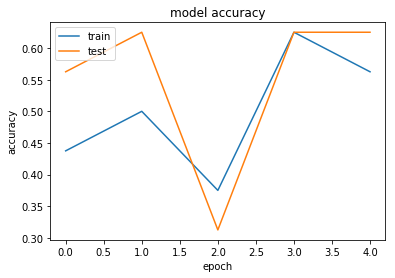

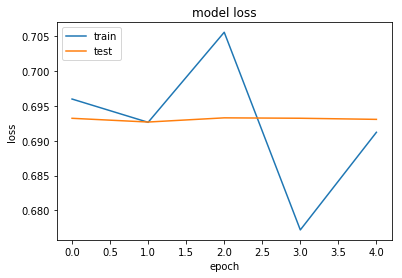

In [11]:
import matplotlib.pyplot as plt

plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

In [13]:
predicts = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

1/1 [==============================] - 0s 309ms/step
No of errors = 8/16


Confusion matrix, without normalization
[[1 7]
 [1 7]]


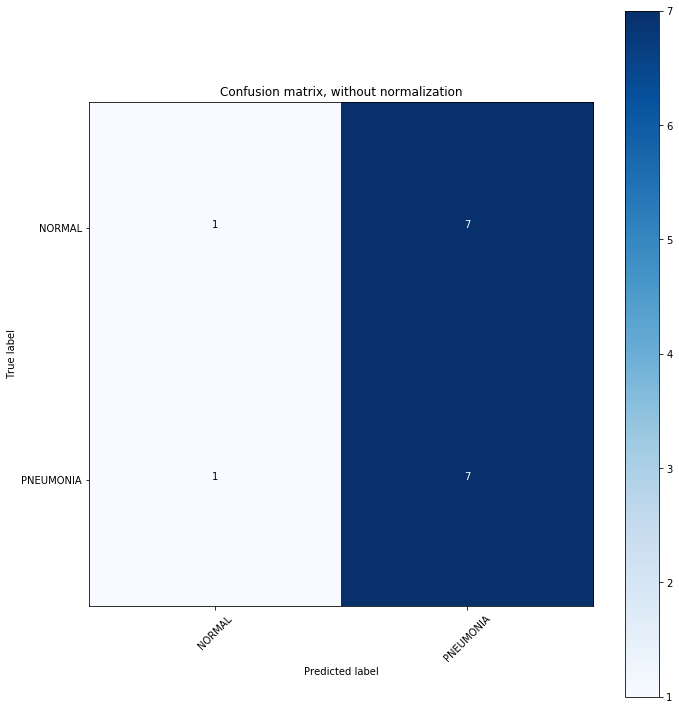

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix, without normalization')

In [15]:
def predict_and_report(gen, model):
    y_true = []
    y_pred = []
    gen.reset()
    for img, label in gen:
        #get true labels for batch and store them
        y_true.extend([int(z[1]) for z in label])
        #Get predictions as probabilities
        batch_pred = model.predict_on_batch(img)
        #turn probabilities to class labels and store
        batch_pred = np.argmax(batch_pred, axis=1)
        y_pred.extend(batch_pred)
        #break loop
        if gen.batch_index == 0:
            break
            
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Area Under the Receiver Operating Characteristic Curve:', roc_auc_score(y_true, y_pred)) #Area under the curve
    print(classification_report(y_true, y_pred))



In [16]:
predict_and_report(train_generator, model)
predict_and_report(validation_generator, model)

Accuracy: 0.625
Area Under the Receiver Operating Characteristic Curve: 0.625
             precision    recall  f1-score   support

          0       0.67      0.50      0.57         8
          1       0.60      0.75      0.67         8

avg / total       0.63      0.62      0.62        16

Accuracy: 0.4375
Area Under the Receiver Operating Characteristic Curve: 0.4375
             precision    recall  f1-score   support

          0       0.33      0.12      0.18         8
          1       0.46      0.75      0.57         8

avg / total       0.40      0.44      0.38        16



In [18]:
best_train_acc = max(result.history['acc'])
best_train_acc

0.625

In [21]:
last_train_acc = result.history['acc'][-1]
last_train_acc

0.5625

In [22]:
print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  0.6933879852294922
Test Accuracy:  0.5


In [23]:
results.append([train_dir, optimizer, num_epochs,last_train_acc, best_train_acc,score[0], score[1]])

In [24]:
import pandas as pd

In [25]:
res = pd.DataFrame(results)
res.columns = ['data', 'optimizer', 'epochs','last_train_accuracy', 'best_training_accuracy','test Score', 'test_accuracy']
res

,data,optimizer,epochs,last_train_accuracy,best_training_accuracy,test Score,test_accuracy
0,data/chest_xray/train,sgd,5,0.5625,0.625,0.693388,0.5


In [26]:
res.to_csv("baselineCNN.csv", sep=',', encoding='utf-8')